# Deep Learning for Time Series Forecasting

In [1]:
#!pip install xgboost==0.7.post4

In [2]:
import numpy as np
import pandas as pd
import re, os, gc, pickle
import seaborn
import matplotlib.pylab as plt
import warnings
from itertools import product
import time
from xgboost import XGBRegressor, plot_importance

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
warnings.filterwarnings('ignore')

## 1. Load data

In [3]:
train = pd.read_csv('sales_train.csv', parse_dates=['date'], infer_datetime_format=True)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


## 3. Load test data

In [5]:
test = pd.read_csv('test.csv')
print(test.shape)
test.info()

(214200, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [6]:
shops = pd.read_csv('shops.csv')
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [7]:
train.loc[train.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
train.loc[train.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

In [8]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [9]:
category = []
for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )
    if len(shops[shops.category == cat]) > 4:
        category.append(cat)

Орджоникидзе, 2
ТЦ 28
ТРК 5
ТРЦ 11
(Плехановская, 1
Торговля 1
ул. 2
ЧС 1
"Распродажа" 1
МТРЦ 1
Магазин 1
ТК 5
склад 1


In [10]:
shops.category = shops.category.apply( lambda x: x if (x in category) else "etc" )

for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )

etc 11
ТЦ 28
ТРК 5
ТРЦ 11
ТК 5


In [11]:
shops["shop_category"] = LabelEncoder().fit_transform(shops.category)
shops["shop_city"] = LabelEncoder().fit_transform(shops.city)

shops = shops[["shop_id", "shop_category", "shop_city"]]

cats = pd.read_csv('item_categories.csv')
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"
cats.shape

(84, 4)

In [12]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
 2   type_code           84 non-null     object
 3   category            15 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.8+ KB


In [13]:
category = []
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))
    if len(cats[cats.type_code == cat]) > 4: 
        category.append( cat )

PC 1
Аксессуары 7
Билеты 1
Доставка 1
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6
Служебные 2
Чистые 2
Элементы 1


In [14]:
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))

etc 8
Аксессуары 7
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6


In [15]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]
cats.head()

,item_category_id,subtype_code,type_code
0,0,29,0
1,1,9,1
2,2,10,1
3,3,11,1
4,4,13,1


In [16]:
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

In [17]:
items = pd.read_csv('items.csv')

items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [18]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
print( group_sum.reset_index() )
group_sum = group_sum.reset_index()

        type  item_id
0          0    17661
1        5c5        1
2        5c7        2
3        5f4        1
4        6dv        1
5        6jv        1
6        6l6        1
7    android        3
8        hm3        1
9        j72        4
10       kf6        1
11       kf7        1
12       kg4        1
13       mac       43
14        pc     2628
15        ps       79
16       ps2        2
17       ps3      611
18       ps4      174
19       psp      115
20       s3v        1
21       s4v        1
22   xbox360      466
23   xboxone      123
24      англ        1
25        рс       14
26   русская        1
27    только        9
28     цифро        1
29  цифровая      222


In [19]:
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] < 40:
        drop_cols.append(cat)

In [20]:
items.name2 = items.name2.apply( lambda x: "etc" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [21]:
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype=np.int16))

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time() - ts

6.841922044754028

In [22]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]

ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16)
time.time() - ts

2.7217137813568115

In [23]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

ts = time.time()
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.03217458724975586

In [24]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

2.1509621143341064

In [25]:
def lag_feature(df, lags, cols):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

ts = time.time()
lags = [1, 2, 3, 4, 5, 6, 10]
matrix = lag_feature(matrix, lags, ["item_cnt_month"])
time.time() - ts

item_cnt_month


23.38789176940918

In [26]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature(matrix, [1,2], ["date_avg_item_cnt"])
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


9.319697856903076

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, lags, ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


26.713048934936523

In [28]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, lags, ["date_shop_avg_item_cnt"])
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_shop_avg_item_cnt


27.33031940460205

In [29]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, lags, ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_shop_item_avg_item_cnt


33.783724784851074

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1, 2, 3], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


15.111337184906006

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1, 2, 3], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


15.414045810699463

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1, 2, 3], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


19.472201347351074

In [33]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
matrix = lag_feature(matrix, lags, ["date_item_avg_item_price"])
for i in lags:
    matrix["delta_price_lag_" + str(i)] = (matrix["date_item_avg_item_price_lag_" + str(i)] - 
                                           matrix["item_avg_item_price"])/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


209.87672686576843

In [34]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1, 2, 3], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


17.239602088928223

In [35]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056323 entries, 0 to 11056322
Data columns (total 54 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   shop_category                         int8   
 5   shop_city                             int8   
 6   item_category_id                      int8   
 7   name2                                 int8   
 8   name3                                 int16  
 9   subtype_code                          int8   
 10  type_code                             int8   
 11  item_cnt_month_lag_1                  float16
 12  item_cnt_month_lag_2                  float16
 13  item_cnt_month_lag_3                  float16
 14  item_cnt_month_lag_4                  float16
 15  item_cnt_mont

In [36]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

ts = time.time()
matrix["item_shop_first_sale"] = (matrix["date_block_num"] - 
                                  matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min'))
matrix["item_first_sale"] = (matrix["date_block_num"] - 
                             matrix.groupby(["item_id"])["date_block_num"].transform('min'))
time.time() - ts

1.0381395816802979

In [37]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.7991225719451904

In [38]:
data = matrix.copy()
del matrix
gc.collect()

40

In [39]:
data[data["date_block_num"]==34].shape

(214200, 58)

In [40]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
X_test.shape

(214200, 57)

In [41]:
#del data
#gc.collect();

In [42]:
ts = time.time()

model = XGBRegressor(max_depth=10, n_estimators=1000, min_child_weight=0.5, colsample_bytree=0.8, 
                     subsample=0.8, eta=0.02, seed=42)

model.fit(X_train, Y_train, eval_metric="rmse", eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
          verbose=True, early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.1781	validation_1-rmse:1.11338
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.13011	validation_1-rmse:1.07854
[2]	validation_0-rmse:1.0861	validation_1-rmse:1.04542
[3]	validation_0-rmse:1.04805	validation_1-rmse:1.02005
[4]	validation_0-rmse:1.01641	validation_1-rmse:0.998422
[5]	validation_0-rmse:0.989762	validation_1-rmse:0.979796
[6]	validation_0-rmse:0.965618	validation_1-rmse:0.964533
[7]	validation_0-rmse:0.946717	validation_1-rmse:0.953839
[8]	validation_0-rmse:0.929526	validation_1-rmse:0.944157
[9]	validation_0-rmse:0.91397	validation_1-rmse:0.935427
[10]	validation_0-rmse:0.901249	validation_1-rmse:0.928858
[11]	validation_0-rmse:0.889134	validation_1-rmse:0.923703
[12]	validation_0-rmse:0.878619	validation_1-rmse:0.917957
[13]	validation_0-rmse:0.868706	validation_1-rmse:0.913706
[14]	validation_0-rmse:0.861049	valid

1406.7349541187286

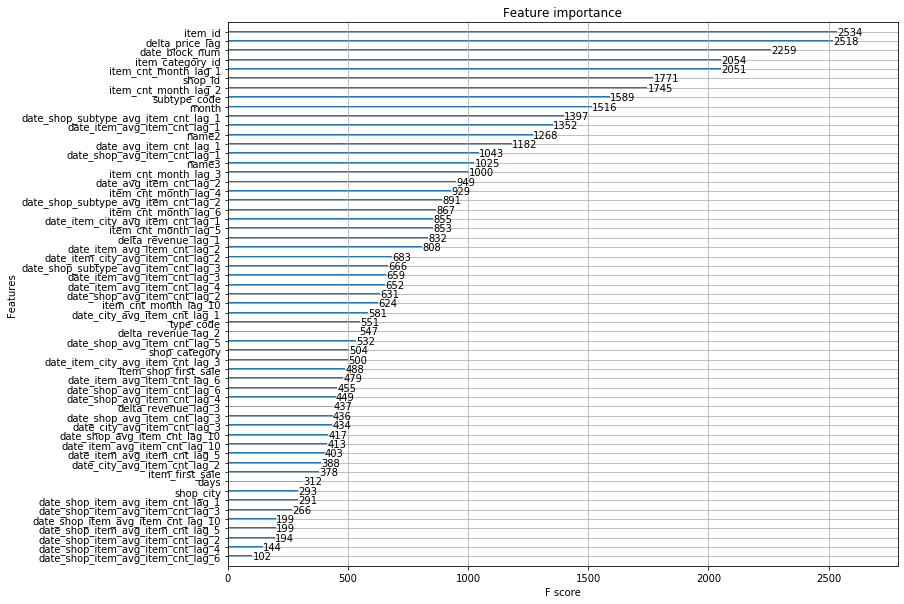

In [43]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (12,10));

In [44]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({"ID": test.index, 
                           "item_cnt_month": Y_test})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))